<a href="https://colab.research.google.com/github/kaiquefreire05/covid-tweets-classification/blob/main/covid_tweets_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importações

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Lendo o dataframe de treino e teste

df_train = pd.read_csv('/content/drive/MyDrive/datasets/Corona_NLP_train.csv', encoding= 'latin-1')
df_test = pd.read_csv('/content/drive/MyDrive/datasets/Corona_NLP_test.csv', encoding= 'latin-1')

In [4]:
# 5 primeiras linhas do dataframe de treino

df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
# 5 primeiras linhas do dataframe de teste

df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [6]:
# Tamanho dos dataframes

print(f'O tamanho da base de treino é de {df_train.shape[0]} linhas e {df_train.shape[1]} colunas.')
print(f'O tamanho da base de teste é de {df_test.shape[0]} linhas e {df_test.shape[1]} colunas.')

O tamanho da base de treino é de 41157 linhas e 6 colunas.
O tamanho da base de teste é de 3798 linhas e 6 colunas.


In [7]:
# Informações dos dataframes

print('Informações da base de treino: \n')
print(df_train.info())
print('\nInformações da base de teste: \n')
print(df_test.info())

Informações da base de treino: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
None

Informações da base de teste: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      

In [8]:
# Verificando se existe valores nulos em ambos dataframes

print(f'Valores nulos no datafame de treino: \n\n{df_train.isnull().sum()}\n')
print(f'Valores nulos no dataframe de teste: \n\n{df_test.isnull().sum()}')

Valores nulos no datafame de treino: 

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Valores nulos no dataframe de teste: 

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64


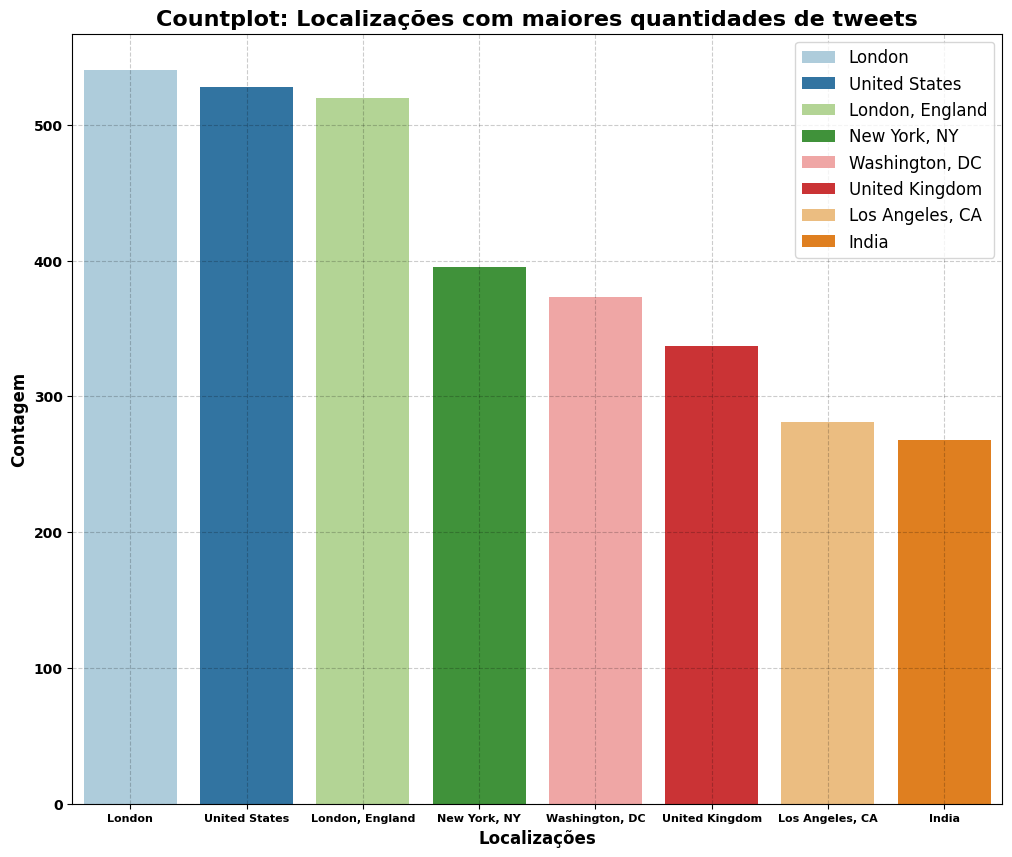

In [9]:
# Localizações com maiores quantidades de tweets

plt.figure(figsize= (12, 10)) # criando figura e definindo seu tamanho
sns.countplot(data= df_train, x= df_train['Location'], order= df_train['Location'].value_counts().index[:8], palette= 'Paired') # contagem de estados/paises com maior tweets de forma ordenada
plt.title('Countplot: Localizações com maiores quantidades de tweets', fontsize= 16, fontweight= 'bold')
plt.legend(labels= (df_train['Location'].value_counts().index[:8]), fontsize= 'large') # criando legende com o índice dos 8 maiores números
plt.ylabel('Contagem', fontsize= 12, fontweight= 'bold')
plt.xlabel('Localizações', fontsize= 12, fontweight= 'bold')
plt.xticks(fontsize= 8, fontweight= 'bold')
plt.yticks(fontsize= 10, fontweight= 'bold')
plt.grid(True, linestyle= '--', color= 'black', alpha= 0.2)
plt.show()

In [10]:
# Visualizando valores únicos da coluna de sentimentos

df_train['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [11]:
# Substituindo resultados do dataframe de treino

df_train['Sentiment'].replace(to_replace= 'Extremely Negative', value= 'Negative', inplace= True)
df_train['Sentiment'].replace(to_replace= 'Extremely Positive', value= 'Positive', inplace= True)
print(df_train['Sentiment'].unique())

['Neutral' 'Positive' 'Negative']


In [12]:
# Substituindo resultados do dataframe de teste

df_test['Sentiment'].replace(to_replace= 'Extremely Negative', value= 'Negative', inplace= True)
df_test['Sentiment'].replace(to_replace= 'Extremely Positive', value= 'Positive', inplace= True)
df_train['Sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

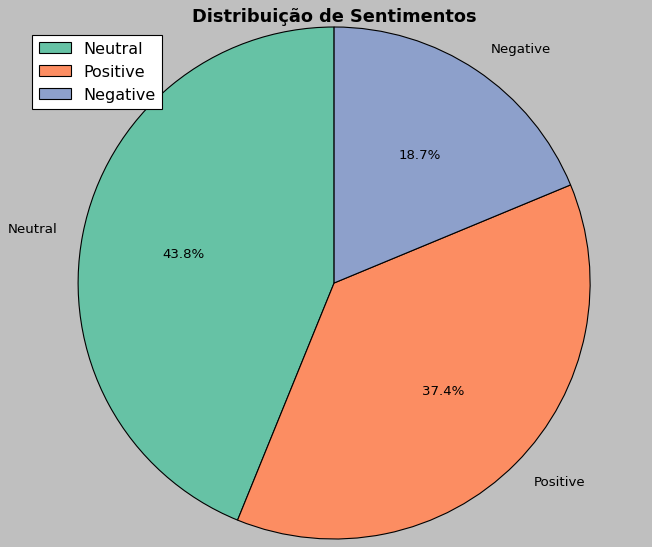

In [13]:
# Gráfico de pizza: Visualização de sentimentos

colors = ['#66c2a5', '#fc8d62', '#8da0cb']
explode = (0, 0.1, 0)
plt.style.use('classic')
plt.figure(figsize=(10, 8))
plt.pie(df_train['Sentiment'].value_counts(), labels= df_train['Sentiment'].unique(), colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de Sentimentos', fontsize= 16, fontweight= 'bold')
plt.legend(loc= 'best', fontsize= 'large')
plt.axis('equal')  # Garante que o gráfico de pizza seja desenhado como um círculo.
plt.show()

In [14]:
# Criando um novo dataframe somente com as colunas de tweets e sentimentos

train_data = df_train[['OriginalTweet', 'Sentiment']]
test_data = df_test[['OriginalTweet', 'Sentiment']]

In [15]:
# 5 primeiros registros do dataframe de treino

train_data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Negative


In [16]:
# 5 primeiros registros do dataset de teste

test_data.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [17]:
# Função para limpar os textos da coluna de tweets

stop_words = stopwords.words('english') # armazendando as stop words em uma variável

def clean_text(text):

    text = text.lower() # converte o texto para minúsculas
    text = re.sub("@\S+", " ", text) # cemove menções a usuários em redes sociais
    text = re.sub("https*\S+", " ", text) # remove URLs
    text = re.sub("#\S+", " ", text) # remove hashtags
    text = re.sub("\d", " ", text) # remove todos os números
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # remove pontuações
    text = re.sub('\n', ' ', text) # remove quebras de linha
    text = re.sub('\s{2,}', ' ', text) # remove espaços extras
    text = ' '.join([word for word in text.split(' ') if word not in stop_words]) # remove as stopwords
    text = re.sub('[^a-zA-Z\s]', '', text) # remove caracteres não-Latinos

    return text

In [18]:
# Aplicando a função na coluna de tweets

train_data['OriginalTweet'] = train_data['OriginalTweet'].apply(clean_text)
test_data['OriginalTweet'] = test_data['OriginalTweet'].apply(clean_text)

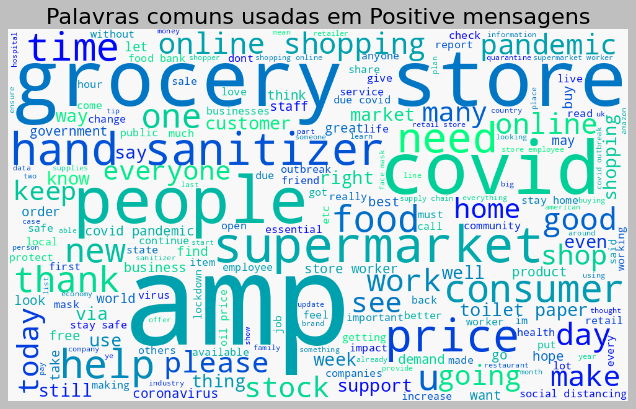

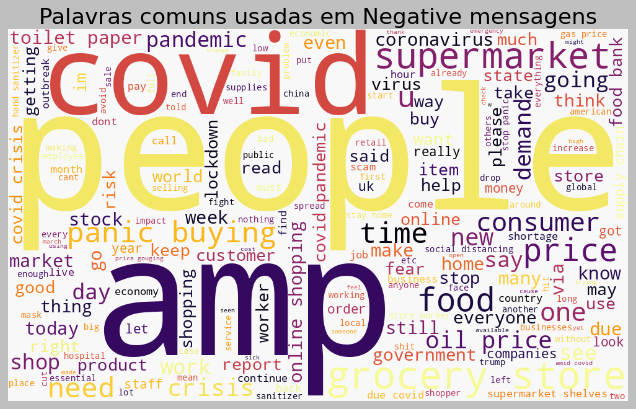

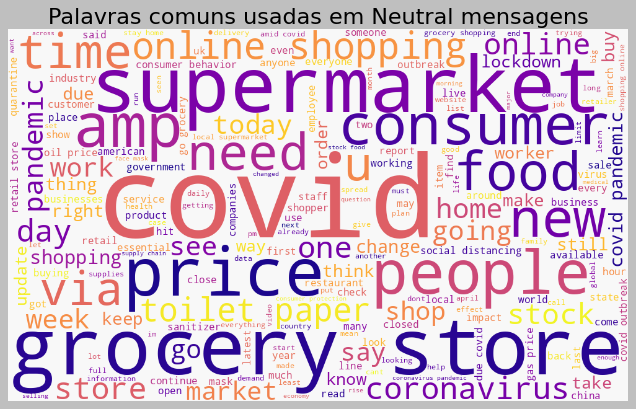

In [19]:
# Loop for para iterar sobre as categorias de sentimento e mapas de cores correspondentes

for label, cmap in zip(['Positive', 'Negative', 'Neutral'], ['winter', 'inferno', 'plasma']):

    text = train_data.query('Sentiment == @label')['OriginalTweet'].str.cat(sep=' ') # consulta ao conjunto de dados para selecionar os tweets da categoria atual
    plt.figure(figsize=(10, 6)) # criação de uma nova figura com tamanho específico
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap) # criação da nuvem de palavras com parâmetros específicos
    wc.generate_from_text(text) # geração da nuvem de palavras a partir do texto concatenado
    plt.imshow(wc) # exibição da nuvem de palavras
    plt.axis("off") # desativação dos eixos
    plt.title(f"Palavras comuns usadas em {label} mensagens", size=20) # definição do título do gráfico
    plt.show() # plotando a figura

In [20]:
# Criando uma nova coluna para transformar os sentimentos em números

target_mapping={'Negative':0, 'Neutral':1, 'Positive':2} # dicionário com sentimento e seu número

train_data['SentimentMapped']= train_data['Sentiment'].map(lambda x:target_mapping[x]) # criando nova coluna no dataframe de treino
test_data['SentimentMapped']= test_data['Sentiment'].map(lambda x:target_mapping[x]) # criando nova coluna no dataframe de teste

In [21]:
# Transformando coluna e dividindo entre variáveis de treino e teste

cv = CountVectorizer(max_features=10000) # criando vetorizidor

x_train = cv.fit_transform(train_data['OriginalTweet']) # encodando somente a coluna de tweets e atribuindo a variável
y_train = train_data['SentimentMapped'] # passando apenas os sentimentos mapeados

x_test = cv.transform(test_data['OriginalTweet'])
y_test = test_data['SentimentMapped']

# Informações das variáveis
print(f'O tamanho das variáveis de treino X e Y é de: {x_train.shape} e {y_train.shape}')
print(f'O tamanho das variáveis de teste X e Y é de: {x_test.shape} e {y_test.shape}')

O tamanho das variáveis de treino X e Y é de: (41157, 10000) e (41157,)
O tamanho das variáveis de teste X e Y é de: (3798, 10000) e (3798,)


In [22]:
# Treinamento usando classificador de rede neural

rn_model = MLPClassifier(random_state=42, early_stopping=True, verbose=2)
rn_model.fit(x_train, y_train)

Iteration 1, loss = 0.72731778
Validation score: 0.819728
Iteration 2, loss = 0.40639149
Validation score: 0.838435
Iteration 3, loss = 0.29360246
Validation score: 0.840379
Iteration 4, loss = 0.22342201
Validation score: 0.837707
Iteration 5, loss = 0.17404255
Validation score: 0.836249
Iteration 6, loss = 0.13399775
Validation score: 0.831147
Iteration 7, loss = 0.10287234
Validation score: 0.830418
Iteration 8, loss = 0.07794761
Validation score: 0.829203
Iteration 9, loss = 0.05985809
Validation score: 0.824587
Iteration 10, loss = 0.04569145
Validation score: 0.823372
Iteration 11, loss = 0.03615401
Validation score: 0.822400
Iteration 12, loss = 0.02884066
Validation score: 0.824830
Iteration 13, loss = 0.02430184
Validation score: 0.820700
Iteration 14, loss = 0.01963101
Validation score: 0.816327
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(early_stopping=True, random_state=42, verbose=2)

In [25]:
# Fazendo previsões

pred_rn = rn_model.predict(x_test)
print(f'A taxa de acurácia do algoritmo foi de: {accuracy_score(y_test, pred_rn)}')
print(f'Relatório de classificação: \n{classification_report(y_test, pred_rn)}\n')
confuse_rn = confusion_matrix(y_test, pred_rn)

A taxa de acurácia do algoritmo foi de: 0.8228014744602422
Relatório de classificação: 
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1633
           1       0.78      0.73      0.76       619
           2       0.82      0.86      0.84      1546

    accuracy                           0.82      3798
   macro avg       0.81      0.81      0.81      3798
weighted avg       0.82      0.82      0.82      3798




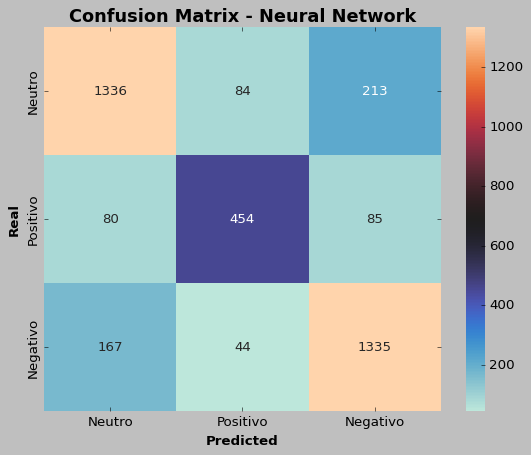

In [28]:
# Matriz de confusão

tags = ['Neutro', 'Positivo', 'Negativo'] # tags dos resultados

plt.figure(figsize= (8, 6)) # criando figura e defindo seu tamanho
sns.heatmap(confuse_rn, annot= True, fmt= 'd', cmap= 'icefire', xticklabels= tags, yticklabels= tags) # passando matriz de confusão, passando tags, mostrando os números e mudando paleta
plt.title('Confusion Matrix - Neural Network', fontsize= 16, fontweight= 'bold') # definindo título
plt.xlabel('Predicted', fontsize= 12, fontweight= 'bold') # definindo eixo X
plt.ylabel('Real', fontsize= 12, fontweight= 'bold') # definindo eixo Y
plt.show() # plotando figura